# TC 5033
## Deep Learning
## Transfer Learning

<br>

#### Activity 2c: Exploring Transfer Learning with CIFAR-10
<br>

Juan Antonio Chiñas Mata: A01794191 <br>
José Alejandro Cortés Pérez: A01795033 <br>
Moises Flores Ortíz: A01795489 <br>
Mardonio Manuel Román Ramírez: A01795265 <br>
Miriam Eunice Rosas Medellín: A01795550 <br><br>

- Objective:

    In this activity, you'll study the concept of Transfer Learning, a powerful technique to improve the performance of your models by leveraging pre-trained architectures. The provided notebook offers a complete solution using a specific pre-trained model on the CIFAR-10 dataset. Your task is to extend this by trying out two other pre-trained models.
    
- Instructions:

    This activity should be submitted in the same format as previous activities. Remember to include the names of all team members in a markdown cell at the beginning of the notebook. The grade obtained in this notebook will be averaged with that of Activity 2b, for the grade of Activity 2.    

    Study the Provided Code: The provided notebook has a complete Transfer Learning solution using a particular pre-trained model. Make sure you understand the flow of the code and the role of each component.

    Select Two Other Pre-trained Models: Choose two different pre-trained models available in PyTorch's model zoo.

    Apply Transfer Learning: Add cells to implement Transfer Learning using the two models you've chosen. Train these models on the CIFAR-10 dataset.

    Evaluation: After training, evaluate your models' performance. Compare the results with the provided solution and try to interpret why there might be differences.

    Documentation: In a markdown cell, summarize your findings. Include any challenges you faced, how you overcame them, and any interesting insights you gained from comparing the different pre-trained models.

- Note:

    Although the provided code serves as a guide, you're encouraged to implement the new solutions on your own. The goal is to reinforce your understanding of Transfer Learning and how to apply it effectively.




In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Import utilities for data loading and handling
from torch.utils.data import DataLoader, sampler

# Import datasets and transformations from torchvision
import torchvision.datasets as datasets
import torchvision.transforms as T

# Import pre-trained models from torchvision
from torchvision import models

### Download datasets

In [ ]:
# Define path to data and constants for training
DATA_PATH = '/content/drive/My Drive/Colab Notebooks/MNA/TC5033 - Deep Learning/Semana_5'
NUM_TRAIN = 45_000  # Number of training samples
MINIBATCH_SIZE = 64  # Batch size for DataLoader

# Image transformation for ImageNet-style input (used for pretrained models)
transform_imagenet = T.Compose([
    T.Resize(224),  # Resize images to 224x224
    T.ToTensor(),  # Convert images to tensors
    T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))  # Normalize using ImageNet mean and std
])

# Image transformation for CIFAR-10
transform_cifar = T.Compose([
    T.ToTensor(),  # Convert images to tensors
    T.Normalize([0.491, 0.482, 0.447], [0.247, 0.243, 0.261])  # Normalize using CIFAR-10 mean and std
])

# Training set loader using ImageNet-style transformations
cifar10_train = datasets.CIFAR10(
    DATA_PATH, train=True, download=True, transform=transform_imagenet
)
train_loader = DataLoader(
    cifar10_train, batch_size=MINIBATCH_SIZE, sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN))
)

# Validation set loader (also uses ImageNet-style transformations)
cifar10_val = datasets.CIFAR10(
    DATA_PATH, train=True, download=True, transform=transform_imagenet
)
val_loader = DataLoader(
    cifar10_val, batch_size=MINIBATCH_SIZE,
    sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, len(cifar10_val)))
)

# Test set loader (no random sampler needed for test set)
cifar10_test = datasets.CIFAR10(
    DATA_PATH, train=False, download=True, transform=transform_imagenet
)
test_loader = DataLoader(cifar10_test, batch_size=MINIBATCH_SIZE)

100%|██████████| 170498071/170498071 [00:05<00:00, 29208309.54it/s]


Extracting /content/drive/My Drive/Colab Notebooks/MNA/TC5033 - Deep Learning/Semana_5/cifar-10-python.tar.gz to /content/drive/My Drive/Colab Notebooks/MNA/TC5033 - Deep Learning/Semana_5
Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Iterate through the training data batches
for i, (x, y) in enumerate(val_loader):
     # Print the batch index and the shapes of input data (x) and labels (y)
     print(f'The batch number {i} has an x with shape {x.shape} and y with shape {y.shape}')

     # After processing the first 5 batches, print a separator and break the loop
     if i == 5:
        print('...')
        break

The batch number 0 has an x with shape torch.Size([64, 3, 224, 224]) and y with shape torch.Size([64])
The batch number 1 has an x with shape torch.Size([64, 3, 224, 224]) and y with shape torch.Size([64])
The batch number 2 has an x with shape torch.Size([64, 3, 224, 224]) and y with shape torch.Size([64])
The batch number 3 has an x with shape torch.Size([64, 3, 224, 224]) and y with shape torch.Size([64])
The batch number 4 has an x with shape torch.Size([64, 3, 224, 224]) and y with shape torch.Size([64])
The batch number 5 has an x with shape torch.Size([64, 3, 224, 224]) and y with shape torch.Size([64])
...


### Check if user is connected to GPU runtime

In [ ]:
# Check if user is connected to GPU runtime
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Print the device being used
print(f'The device being used is {device}')

The device being used is cuda


### Show images

This code randomly selects an image from the test dataset and visualizes it, ensuring that the image is properly displayed by normalizing its pixel values and removing axis labels. It is intended to show that the dataset is composed of different image classes from which we are going to create two different neural network models with the objective of classifying them.

The sampled image represents a: automobile


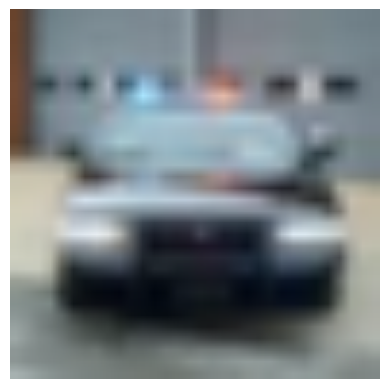

In [ ]:
# Get the list of class labels from the test dataset
classes = test_loader.dataset.classes

# Function to plot an image without axis labels
def plot_figure(image):
    """
    Plots a single image by adjusting its channel order for proper display.

    Args:
        image (Tensor or numpy array): A 3D tensor or numpy array representing
        an image with the shape (C, H, W), where C is the number of channels,
        H is the height, and W is the width. The channels are assumed to be
        in the format expected by Matplotlib (i.e., RGB channels).

    Returns:
        None
    """
    # Plot the image, adjusting the channel order for display
    plt.imshow(np.transpose(image, (1, 2, 0)))
    plt.axis('off')  # Remove the axis
    plt.show()  # Display the image

# Randomly sample an index from the test dataset
rnd_sample_idx = np.random.randint(len(test_loader))

# Print the class of the sampled image
print(f'The sampled image represents a: {classes[test_loader.dataset[rnd_sample_idx][1]]}')

# Get the image corresponding to the random index
image = test_loader.dataset[rnd_sample_idx][0]

# Normalize the image to have values between 0 and 1 for display
image = (image - image.min()) / (image.max() - image.min())

# Plot the normalized image
plot_figure(image)

### Calculate accuracy

The accuracy function is designed to compute the classification accuracy of a deep learning model on a given dataset, which is provided through a data loader. Accuracy, in this context, is the proportion of correct predictions made by the model compared to the total number of samples. This function is essential for evaluating the performance of a model during both training and validation phases.

In [ ]:
def accuracy(model, loader):
    """
    Computes the accuracy of the given model on the provided data loader.

    Args:
        model (torch.nn.Module): The model to be evaluated.
        loader (torch.utils.data.DataLoader): The data loader that provides the input samples and labels.

    Returns:
        float: The accuracy of the model on the given dataset, expressed as a value between 0 and 1.

    The function performs the following steps:
    1. Sets the model to evaluation mode and moves it to the specified device (e.g., GPU or CPU).
    2. Iterates over the data loader, which provides batches of input samples and corresponding labels.
    3. For each batch, it performs the following:
        - Moves the inputs and labels to the appropriate device.
        - Performs a forward pass through the model to get prediction scores.
        - Determines the predicted class by selecting the class with the highest score.
        - Compares the predictions with the true labels and counts the number of correct predictions.
    4. Computes the accuracy as the ratio of correct predictions to the total number of samples.
    """
    # Initialize counters for the number of correct predictions and total samples
    num_correct = 0
    num_total = 0

    # Set the model to evaluation mode and move it to the specified device
    model.eval()
    model = model.to(device=device)

    # Disable gradient computation for inference
    with torch.no_grad():
        # Iterate through the data loader
        for xi, yi in loader:
            # Move inputs and labels to the specified device and set data types
            xi = xi.to(device=device, dtype=torch.float32)
            yi = yi.to(device=device, dtype=torch.long)

            # Get the model's output scores
            scores = model(xi)

            # Get the predicted class by selecting the class with the highest score
            _, pred = scores.max(dim=1)

            # Update the number of correct predictions
            num_correct += (pred == yi).sum()

            # Update the total number of samples processed
            num_total += pred.size(0)

    # Return the accuracy as a float value
    return float(num_correct) / num_total

### Load pre-trained model

In [ ]:
# Load a pre-trained ResNet-18 model from torchvision
model_resnet18 = models.resnet18(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 131MB/s]


#### Exploremos el modelo

In [ ]:
# Iterate over the parameters of the ResNet-18 model
for i, w in enumerate(model_resnet18.parameters()):
    # Print the index, shape of the parameter tensor, and whether it requires gradient computation
    print(i, w.shape, w.requires_grad)

0 torch.Size([64, 3, 7, 7]) True
1 torch.Size([64]) True
2 torch.Size([64]) True
3 torch.Size([64, 64, 3, 3]) True
4 torch.Size([64]) True
5 torch.Size([64]) True
6 torch.Size([64, 64, 3, 3]) True
7 torch.Size([64]) True
8 torch.Size([64]) True
9 torch.Size([64, 64, 3, 3]) True
10 torch.Size([64]) True
11 torch.Size([64]) True
12 torch.Size([64, 64, 3, 3]) True
13 torch.Size([64]) True
14 torch.Size([64]) True
15 torch.Size([128, 64, 3, 3]) True
16 torch.Size([128]) True
17 torch.Size([128]) True
18 torch.Size([128, 128, 3, 3]) True
19 torch.Size([128]) True
20 torch.Size([128]) True
21 torch.Size([128, 64, 1, 1]) True
22 torch.Size([128]) True
23 torch.Size([128]) True
24 torch.Size([128, 128, 3, 3]) True
25 torch.Size([128]) True
26 torch.Size([128]) True
27 torch.Size([128, 128, 3, 3]) True
28 torch.Size([128]) True
29 torch.Size([128]) True
30 torch.Size([256, 128, 3, 3]) True
31 torch.Size([256]) True
32 torch.Size([256]) True
33 torch.Size([256, 256, 3, 3]) True
34 torch.Size([25

### ResNet-18 Architecture
Each tensor represents the weights of a convolutional layer or the parameters of a residual block in the network.

### 1. **Initial Layers**:
   - `0 torch.Size([64, 3, 7, 7])`: The first convolutional layer with 64 filters, each of size 7x7, and 3 input channels (RGB).
   - `1 torch.Size([64])`, `2 torch.Size([64])`: Bias and BatchNorm parameters associated with this layer.

### 2. **First Group of Residual Layers (Blocks 1 and 2)**:
   - Tensors like `torch.Size([64, 64, 3, 3])` correspond to convolutional layers inside the residual blocks, with 64 filters and a 3x3 kernel size. These represent the first group of residual blocks that operate with 64 filters.
   - `torch.Size([128, 64, 1, 1])`: In the second group of blocks, a 1x1 projection layer is used to increase the depth from 64 to 128 filters.

### 3. **Intermediate Layers and Projections**:
   - `torch.Size([128, 128, 3, 3])`, `torch.Size([128, 64, 1, 1])`: These layers belong to the second stage of residual blocks, where the depth increases to 128 filters.
   - The same pattern follows for later stages with `256` and `512` filters, corresponding to deeper residual blocks.

### 4. **Final Layers**:
   - `torch.Size([512, 256, 1, 1])`, `torch.Size([512, 512, 3, 3])`: In the last set of residual blocks, the number of filters increases to 512.
   - `torch.Size([1000, 512])`: The fully connected (FC) layer that reduces the features to 1000 outputs, which correspond to the 1000 ImageNet classes.


In [ ]:
# See the architecture of the model
model_resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### ResNet Architecture
The architecture of ResNet (Residual Network) consists of several key components, primarily using **residual blocks** to improve learning through skip connections. Here’s a brief explanation of its structure:

- **Conv1**: The first layer is a convolutional layer with a 7x7 kernel, 64 output channels, and a stride of 2. It reduces the spatial dimensions of the input.
- **BatchNorm & ReLU**: A batch normalization layer follows the convolution, normalizing the outputs, followed by a ReLU activation function.
- **MaxPool**: A 3x3 max-pooling layer with stride 2 reduces the spatial resolution further.

The core of the architecture is organized into **residual blocks**:

- **Layer1 to Layer4**: Each of these layers consists of multiple **BasicBlocks**. Each block contains two convolutional layers with batch normalization and ReLU activations. The number of output channels increases from 64 to 128, 256, and finally 512 as we progress through the layers. The "downsample" layers are used to match the dimensions between input and output for skip connections.
  - **Layer 1**: Contains BasicBlocks with 64 filters.
  - **Layer 2**: Contains BasicBlocks with 128 filters.
  - **Layer 3**: Contains BasicBlocks with 256 filters.
  - **Layer 4**: Contains BasicBlocks with 512 filters.

- **AdaptiveAvgPool**: This layer performs an adaptive average pooling, reducing the feature map to a 1x1 spatial dimension, preserving the channel information.
- **Fully Connected Layer (fc)**: The final fully connected layer has 512 input features and 1000 output features, corresponding to the 1000 classes of the ImageNet dataset.

The use of **skip connections** in the residual blocks enables the model to learn more effectively, mitigating the vanishing gradient problem in very deep networks.


#### Adjust the model

In [ ]:
# Create a new model by extracting all layers from the pre-trained ResNet-18 except the fully connected layer.
model_aux = nn.Sequential(*list(model_resnet18.children()))

# Display the modified model (excluding the final fully connected layer)
model_aux

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [ ]:
# By slicing the list with '[:-1]', we remove the last fully connected layer, keeping all other layers.
model_aux = nn.Sequential(*list(model_resnet18.children())[:-1])

# Display the modified model (excluding the fully connected layer and retaining all other layers)
model_aux

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [ ]:
# Loop through all parameters of the model_aux (which excludes the fully connected layer).
# Set 'requires_grad' to False for all parameters, meaning these parameters will not be updated during backpropagation.
for i, parameter in enumerate(model_aux.parameters()):
    parameter.requires_grad = False

In [ ]:
# Loop through all parameters of the model_aux and print the index and whether 'requires_grad' is set to True or False.
for i, parameter in enumerate(model_aux.parameters()):
    print(f'The parameter {i} backpropagation update is set to {parameter.requires_grad}')

The parameter 0 backpropagation update is set to False
The parameter 1 backpropagation update is set to False
The parameter 2 backpropagation update is set to False
The parameter 3 backpropagation update is set to False
The parameter 4 backpropagation update is set to False
The parameter 5 backpropagation update is set to False
The parameter 6 backpropagation update is set to False
The parameter 7 backpropagation update is set to False
The parameter 8 backpropagation update is set to False
The parameter 9 backpropagation update is set to False
The parameter 10 backpropagation update is set to False
The parameter 11 backpropagation update is set to False
The parameter 12 backpropagation update is set to False
The parameter 13 backpropagation update is set to False
The parameter 14 backpropagation update is set to False
The parameter 15 backpropagation update is set to False
The parameter 16 backpropagation update is set to False
The parameter 17 backpropagation update is set to False
Th

### Training loop

### `train` function parameters

- **`model (torch.nn.Module)`**: Defines the architecture of the neural network to be trained. The model contains the layers and the forward pass logic that will learn from the data.
  
- **`optimiser (torch.optim.Optimizer)`**: Responsible for updating the model's parameters using the computed gradients. It determines how the weights are adjusted to minimize the loss.
  
- **`epochs (int, optional)`**: Specifies how many times the entire dataset will be passed through the model. More epochs allow the model to learn more, but excessive epochs can lead to overfitting.

In [ ]:
def train(model, optimiser, epochs=100):
    """
    Trains a model using a specified optimizer for a given number of epochs.

    Args:
        model (torch.nn.Module): The model to be trained.
        optimiser (torch.optim.Optimizer): The optimizer used to update the model's parameters.
        epochs (int, optional): The number of epochs to train the model. Defaults to 100.

    Returns:
        None

    The function trains the model in the following steps:
    1. Moves the model to the specified device (GPU or CPU).
    2. Iterates over the specified number of epochs.
    3. For each epoch, it performs the following:
        - Iterates over the training data loader.
        - Sets the model to training mode.
        - Moves input data and labels to the specified device.
        - Performs a forward pass to compute predictions.
        - Computes the cross-entropy loss between predictions and ground truth.
        - Performs a backward pass to compute gradients.
        - Updates the model parameters using the optimizer.
        - Evaluates the model on the validation set after every epoch.
        - Prints the current epoch, loss, and accuracy.
    """
    # Move the model to the specified device
    model = model.to(device=device)

    # Iterate over the specified number of epochs
    for epoch in range(epochs):
        # Iterate through the training data loader
        for i, (xi, yi) in enumerate(train_loader):
            # Set the model to training mode
            model.train()

            # Move inputs and labels to the specified device and set data types
            xi = xi.to(device=device, dtype=torch.float32)
            yi = yi.to(device=device, dtype=torch.long)

            # Forward pass: Get model's predictions
            scores = model(xi)

            # Compute the cross-entropy loss
            cost = F.cross_entropy(input=scores, target=yi)

            # Zero the gradients of the optimiser
            optimiser.zero_grad()

            # Backward pass: Compute gradients
            cost.backward()

            # Update the model's parameters
            optimiser.step()

        # Evaluate the model on the validation set after each epoch
        acc = accuracy(model, val_loader)

        # Print the current epoch, loss, and accuracy
        print(f'Epoch: {epoch}, Loss: {cost.item()}, Accuracy: {acc}')

In [ ]:
# Set the learning rate and number of epochs for training
lr = 5e-4  # Learning rate
epochs = 3  # Number of training epochs

# Define a new model (model1) by adding a fully connected layer to the pre-trained model (model_aux)
# We then add a Flatten layer to reshape the output, followed by a new Linear layer for classification into 10 classes.
model1 = nn.Sequential(
    model_aux,
    nn.Flatten(),  # Flatten the output from the previous layer into a 1D tensor
    nn.Linear(in_features=512, out_features=10, bias=True)  # Linear layer with 512 input features and 10 output classes
)

# Define the optimizer (Adam) with the specified learning rate and beta values for momentum
optimiser = torch.optim.Adam(model1.parameters(), lr=lr, betas=(0.9, 0.999))

In [ ]:
# Show that there are 10 output features
model1

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [ ]:
# Train model
train(model1, optimiser, epochs)

Epoch: 0, Loss: 0.790684163570404, Accuracy: 0.7782
Epoch: 1, Loss: 0.6145380735397339, Accuracy: 0.7976
Epoch: 2, Loss: 1.103737235069275, Accuracy: 0.807


In [ ]:
# Display accuracy of model 1
accuracy(model1, test_loader)

0.7947

## Model 2

In [ ]:
# Load a pre-trained AlexNet model from torchvision
model_alexnet = models.alexnet(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 178MB/s]


In [ ]:
# By slicing the list with '[:-1]', we remove the last fully connected layer, keeping all other layers.
model_alxnet = nn.Sequential(*list(model_alexnet.children())[:-1])

# Display the modified model (excluding the fully connected layer and retaining all other layers)
model_alxnet

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): AdaptiveAvgPool2d(output_size=(6, 6))
)

The output shape from model_alxnet is (256, 6, 6), so we need to flatten it to get a feature vector of size 256 * 6 * 6 = 9216. So, in this case, the input features for the final layer are 9216.

In [ ]:
# Loop through all parameters of the model_alxnet (which excludes the fully connected layer).
# Set 'requires_grad' to False for all parameters, meaning these parameters will not be updated during backpropagation.
for i, parameter in enumerate(model_alxnet.parameters()):
    parameter.requires_grad = False

In [ ]:
# Set the learning rate and number of epochs for training
lr = 5e-4  # Learning rate
epochs = 3  # Number of training epochs

# Define a new model (model2) by adding a fully connected layer to the pre-trained model (model_alxnet)
# We then add a Flatten layer to reshape the output, followed by a new Linear layer for classification into 10 classes.
model2 = nn.Sequential(
    model_alxnet,
    nn.Flatten(),  # Flatten the output from the previous layer into a 1D tensor
    nn.Linear(in_features=9216, out_features=10, bias=True)  # Linear layer with 9216 input features and 10 output classes
)

# Define the optimizer (Adam) with the specified learning rate and beta values for momentum
optimiser = torch.optim.Adam(model2.parameters(), lr=lr, betas=(0.9, 0.999))

In [ ]:
# Train model
train(model2, optimiser, epochs)

Epoch: 0, Loss: 0.5744870901107788, Accuracy: 0.8342
Epoch: 1, Loss: 0.3741002678871155, Accuracy: 0.8324
Epoch: 2, Loss: 0.3180358111858368, Accuracy: 0.8416


In [ ]:
# Display accuracy of model 2
accuracy(model2, test_loader)

0.831

## Model 3

In [ ]:
# Load a pre-trained DenseNet161 model from torchvision
model_dn161 = models.densenet161(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet161_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet161_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth
100%|██████████| 110M/110M [00:03<00:00, 34.5MB/s]


In [ ]:
# By slicing the list with '[:-1]', we remove the last fully connected layer, keeping all other layers.
model_dn161 = nn.Sequential(*list(model_dn161.children())[:-1])

# Display the modified model (excluding the fully connected layer and retaining all other layers)
model_dn161

Sequential(
  (0): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): 

In [ ]:
# Loop through all parameters of the model_dn161 (which excludes the fully connected layer).
# Set 'requires_grad' to False for all parameters, meaning these parameters will not be updated during backpropagation.
for i, parameter in enumerate(model_dn161.parameters()):
    parameter.requires_grad = False

The output shape from model_alxnet is (2208, 7, 7), so we need to flatten it to get a feature vector of size 2208 * 7 * 7 = 108192. So, in this case, the input features for the final layer are 108192.

In [ ]:
# Set the learning rate and number of epochs for training
lr = 5e-4  # Learning rate
epochs = 3  # Number of training epochs

# Define a new model (model3) by adding a fully connected layer to the pre-trained model (model_dn161)
# We then add a Flatten layer to reshape the output, followed by a new Linear layer for classification into 10 classes.
model3 = nn.Sequential(
    model_dn161,
    nn.Flatten(),  # Flatten the output from the previous layer into a 1D tensor
    nn.Linear(in_features=108192, out_features=10, bias=True)  # Linear layer with 1081192 input features and 10 output classes
)

# Define the optimizer (Adam) with the specified learning rate and beta values for momentum
optimiser = torch.optim.Adam(model3.parameters(), lr=lr, betas=(0.9, 0.999))

In [ ]:
# Train model
train(model3, optimiser, epochs)

Epoch: 0, Loss: 2.9293808937072754, Accuracy: 0.847
Epoch: 1, Loss: 0.8778688311576843, Accuracy: 0.862
Epoch: 2, Loss: 1.4943995475769043, Accuracy: 0.8544


In [ ]:
# Display accuracy of model 3
accuracy(model3, test_loader)

0.8519

## Model 4

In [ ]:
vgg16 = models.vgg16(pretrained=True)
model_aux_vgg = nn.Sequential(*list(vgg16.features.children()))

In [ ]:
model_aux_vgg

In [ ]:
#Clase que define un modelo basado en VGG16.
#Args: num_classes (int): Número de clases para la clasificación.
#Métodos: forward(x): Realiza la pasada hacia adelante a través del modelo.

class VGG16Model(nn.Module):
    def __init__(self, num_classes):
    #Inicializa el modelo VGG16 y ajusta la capa final para el número de clases.
        super(VGG16Model, self).__init__()
        self.model = vgg16

    def forward(self, x):
        return self.model(x)


In [ ]:
# Freeze layers for VGG16
for param in vgg16.features.parameters():
    param.requires_grad = False

# Freeze layers for DenseNet121
#for param in densenet121.parameters():
  #  param.requires_grad = False

In [ ]:
num_classes = 10  #number of classes
vgg_model = VGG16Model(num_classes=10)

In [ ]:
optimiser = torch.optim.Adam(vgg_model.parameters(), lr=lr, betas=(0.9, 0.999))
train(vgg_model, optimiser, epochs=3)

In [ ]:
# Display accuracy of model 3
accuracy(vgg_model, test_loader)

## Conclusion
This notebook explores the concept of Transfer Learning using pre-trained models in PyTorch with the CIFAR-10 dataset. Four models were trained: ResNet-18, AlexNet, DenseNet161 and VGG and their performance was compared. The models ResNet-18, AlexNet, DenseNet161 and VGG show an accuracy between 80% and 85%. Nevertheless, some are more complex than others. Densenet161 takes a long time training and it has a complicated architecture with many layers.

It comes handy to use pre-trained models for image classification since you are not required to train a complex model from scratch.


